**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from torch.amp import GradScaler, autocast

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 1
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [ ]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# TODO: Uncomment to extract data from zip
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=mean, std=std)
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224,224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=mean, std=std)
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [11]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using DenseNet121 as the base model.
    """
    def __init__(self, device, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained DenseNet121
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to((device))

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier(device)
model.to(device)

MultiLabelClassifier(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

**Use Multiple GPUs**

In [12]:
model = nn.DataParallel(model)

# **Step 4: Train the Model**

**Training Loop Function**

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # For mixed precision
    scaler = GradScaler()

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [14]:
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [16]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:12<00:00, 28.99it/s, Loss=0.134] 


Epoch 1/3 | Training Loss: 0.1752 | Validation Loss: 0.1695 | Validation mAUC: 0.7254
New best model with Validation mAUC: 0.7254


Epoch 2/3: 100%|██████████| 351/351 [00:12<00:00, 28.92it/s, Loss=0.135] 


Epoch 2/3 | Training Loss: 0.1710 | Validation Loss: 0.1666 | Validation mAUC: 0.7305
New best model with Validation mAUC: 0.7305


Epoch 3/3: 100%|██████████| 351/351 [00:11<00:00, 29.46it/s, Loss=0.154] 


Epoch 3/3 | Training Loss: 0.1704 | Validation Loss: 0.1698 | Validation mAUC: 0.7352
New best model with Validation mAUC: 0.7352


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [17]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [18]:
optimizer_full = optim.AdamW(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [19]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:11<00:00, 29.44it/s, Loss=0.116] 


Epoch 1/100 | Training Loss: 0.1577 | Validation Loss: 0.1508 | Validation mAUC: 0.8148
New best model with Validation mAUC: 0.8148


Epoch 2/100: 100%|██████████| 351/351 [00:12<00:00, 28.62it/s, Loss=0.123] 


Epoch 2/100 | Training Loss: 0.1495 | Validation Loss: 0.1468 | Validation mAUC: 0.8255
New best model with Validation mAUC: 0.8255


Epoch 3/100: 100%|██████████| 351/351 [00:12<00:00, 29.12it/s, Loss=0.123] 


Epoch 3/100 | Training Loss: 0.1457 | Validation Loss: 0.1467 | Validation mAUC: 0.8308
New best model with Validation mAUC: 0.8308


Epoch 4/100: 100%|██████████| 351/351 [00:12<00:00, 29.20it/s, Loss=0.143] 


Epoch 4/100 | Training Loss: 0.1426 | Validation Loss: 0.1459 | Validation mAUC: 0.8340
New best model with Validation mAUC: 0.8340


Epoch 5/100: 100%|██████████| 351/351 [00:11<00:00, 29.43it/s, Loss=0.144] 


Epoch 5/100 | Training Loss: 0.1400 | Validation Loss: 0.1456 | Validation mAUC: 0.8353
New best model with Validation mAUC: 0.8353


Epoch 6/100: 100%|██████████| 351/351 [00:12<00:00, 28.76it/s, Loss=0.132] 


Epoch 6/100 | Training Loss: 0.1367 | Validation Loss: 0.1452 | Validation mAUC: 0.8361
New best model with Validation mAUC: 0.8361


Epoch 7/100: 100%|██████████| 351/351 [00:16<00:00, 20.74it/s, Loss=0.135] 


Epoch 7/100 | Training Loss: 0.1337 | Validation Loss: 0.1461 | Validation mAUC: 0.8330


Epoch 8/100: 100%|██████████| 351/351 [00:16<00:00, 21.43it/s, Loss=0.132] 


Epoch 8/100 | Training Loss: 0.1303 | Validation Loss: 0.1489 | Validation mAUC: 0.8279


Epoch 9/100: 100%|██████████| 351/351 [00:12<00:00, 28.86it/s, Loss=0.127] 


Epoch 9/100 | Training Loss: 0.1189 | Validation Loss: 0.1478 | Validation mAUC: 0.8340


Epoch 10/100: 100%|██████████| 351/351 [00:16<00:00, 21.57it/s, Loss=0.134] 


Epoch 10/100 | Training Loss: 0.1144 | Validation Loss: 0.1497 | Validation mAUC: 0.8315


Epoch 11/100: 100%|██████████| 351/351 [00:11<00:00, 29.29it/s, Loss=0.135] 


Epoch 11/100 | Training Loss: 0.1114 | Validation Loss: 0.1498 | Validation mAUC: 0.8312


Epoch 12/100: 100%|██████████| 351/351 [00:17<00:00, 20.41it/s, Loss=0.137] 


Epoch 12/100 | Training Loss: 0.1110 | Validation Loss: 0.1499 | Validation mAUC: 0.8319


Epoch 13/100: 100%|██████████| 351/351 [00:16<00:00, 21.83it/s, Loss=0.134] 


Epoch 13/100 | Training Loss: 0.1108 | Validation Loss: 0.1498 | Validation mAUC: 0.8299


Epoch 14/100: 100%|██████████| 351/351 [00:15<00:00, 22.18it/s, Loss=0.137] 


Epoch 14/100 | Training Loss: 0.1106 | Validation Loss: 0.1500 | Validation mAUC: 0.8305


Epoch 15/100: 100%|██████████| 351/351 [00:12<00:00, 29.17it/s, Loss=0.137] 


Epoch 15/100 | Training Loss: 0.1104 | Validation Loss: 0.1501 | Validation mAUC: 0.8297


Epoch 16/100: 100%|██████████| 351/351 [00:12<00:00, 29.21it/s, Loss=0.138] 


Epoch 16/100 | Training Loss: 0.1106 | Validation Loss: 0.1501 | Validation mAUC: 0.8312
Early stopping.


# **Step 5: Evaluate the Model**

**Evaluate the Model on Test Set**

In [20]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Apply sigmoid
            predictions = torch.sigmoid(outputs)

            # Store predictions and true labels
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())
            

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [00:21<00:00, 32.30it/s]


**Compute Metrics for Each Label**

In [21]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [22]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.903561,0.538902,0.813406
Consolidation,0.957298,0.491183,0.814691
Infiltration,0.811788,0.555529,0.704201
Pneumothorax,0.953889,0.615640,0.872941
Edema,0.977752,0.538487,0.892561
Emphysema,0.976496,0.674502,0.915219
Fibrosis,0.983628,0.495873,0.809915
Effusion,0.899345,0.668174,0.880828
Pneumonia,0.986813,0.496681,0.737183
Pleural_Thickening,0.969992,0.504060,0.794977


**Plot ROC curves for each label**

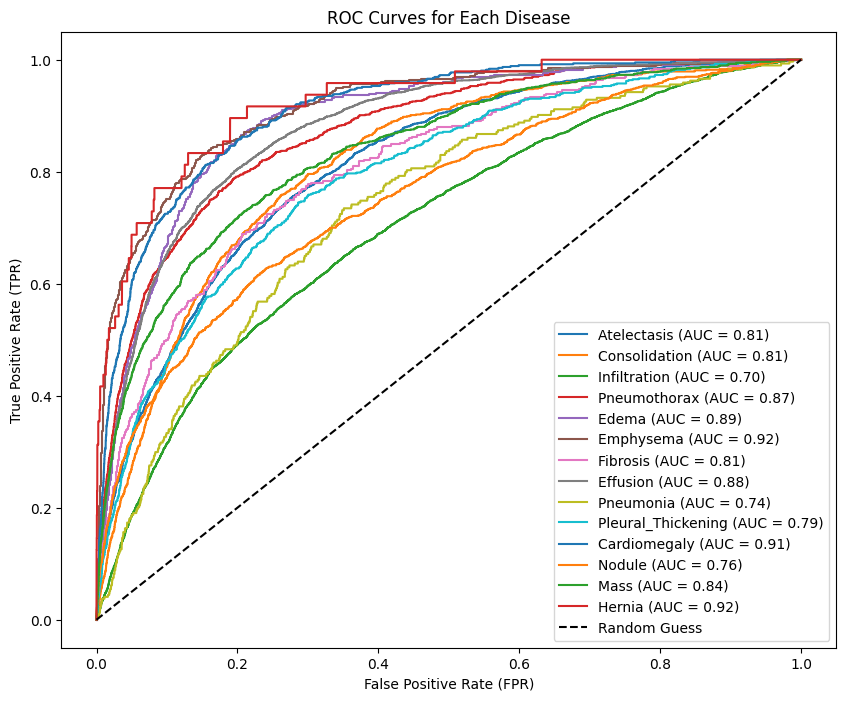

In [23]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Disease')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

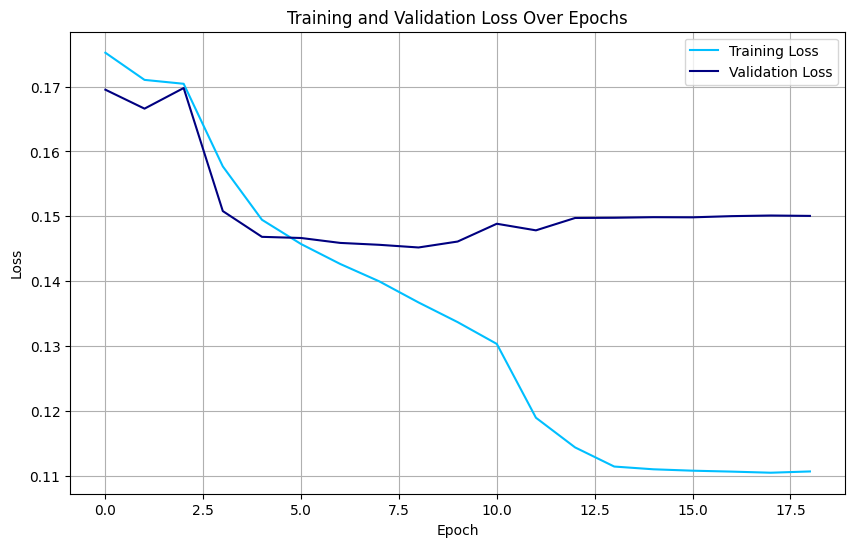

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

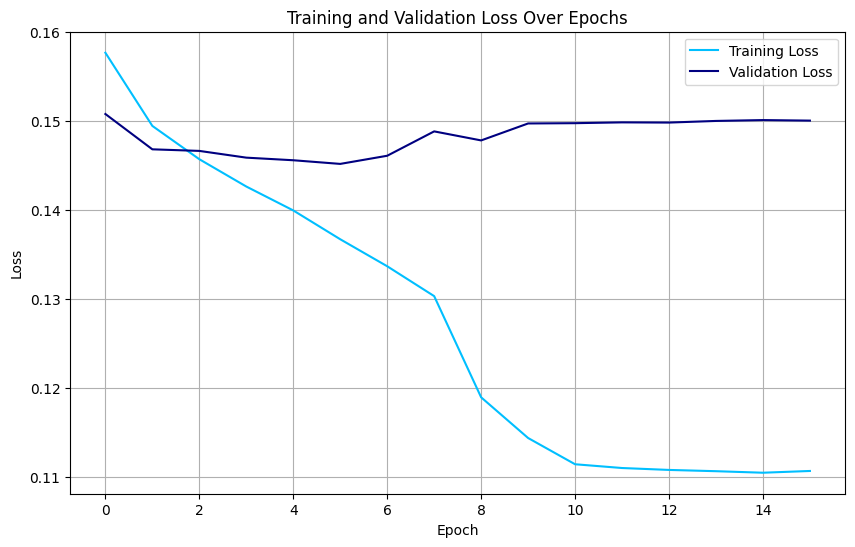

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

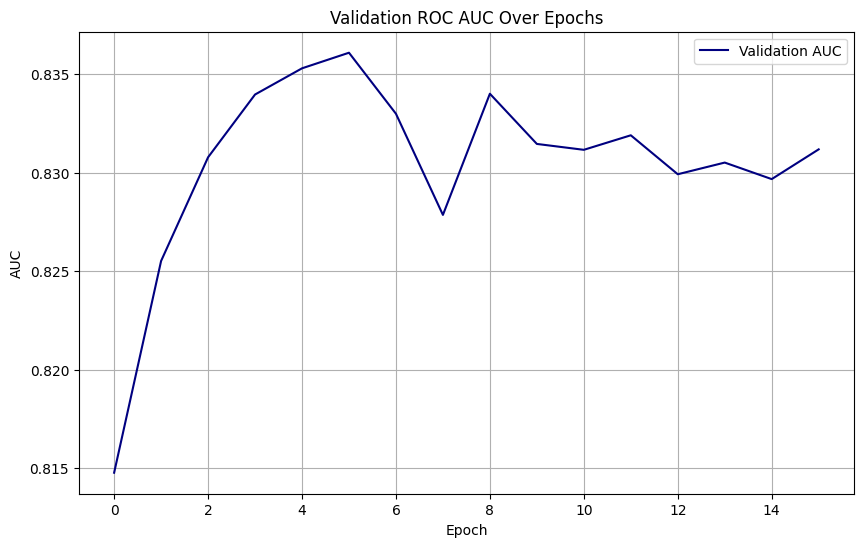

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

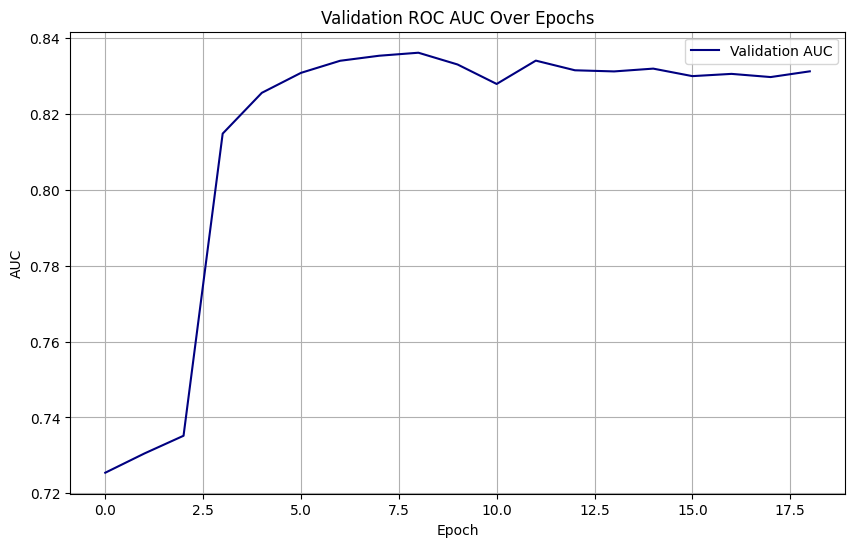

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()